interactive(children=(FloatSlider(value=0.0, description='Shock Demanda (DD/DA) 📈', max=50.0, min=-50.0, step=…

2025-09-23 09:00:04.817 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-23 09:00:04.818 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-23 09:00:05.678 
  command:

    streamlit run c:\Users\IN_CAP02\AppData\Local\miniconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-23 09:00:05.678 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-23 09:00:05.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-23 09:00:05.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-23 09:00:05.680 Thread 'MainThread': missing ScriptRunContext! This warning can be

DeltaGenerator()

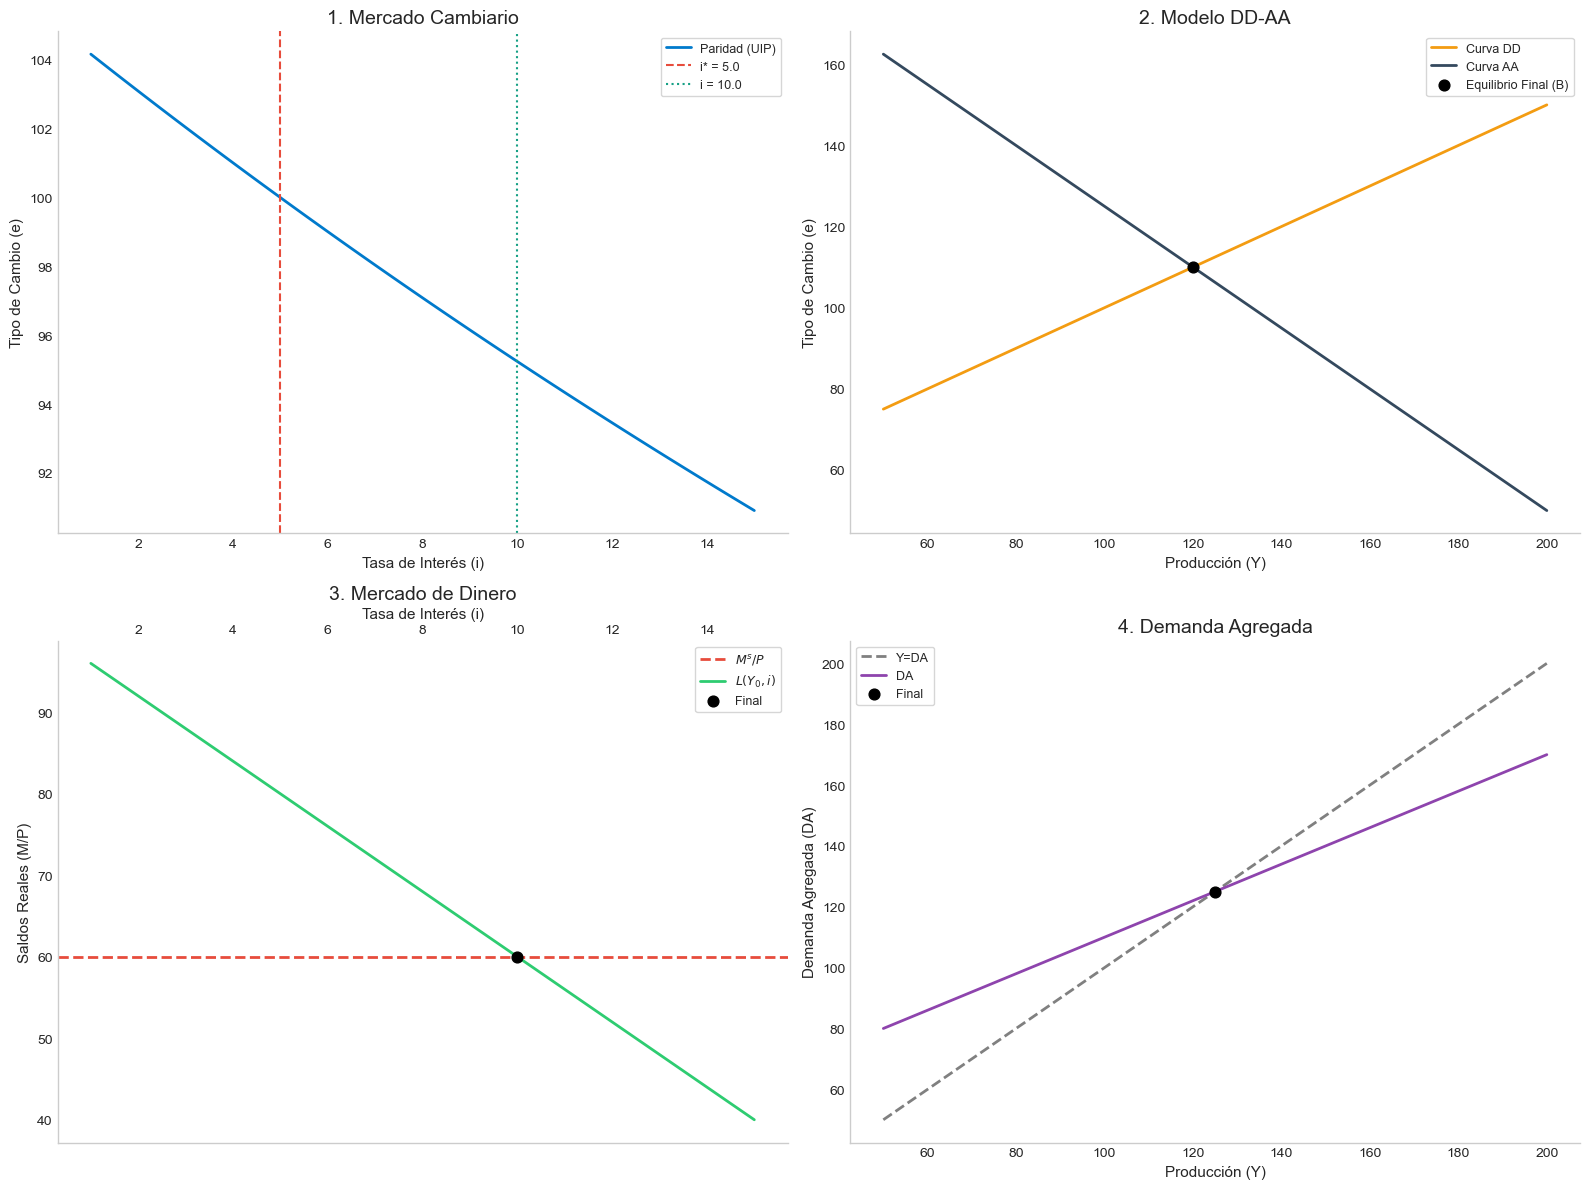

In [ ]:
# --- 1. Importación de Librerías ---
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import streamlit as st
from ipywidgets import interact

# ==============================================================================
# --- 2. Configuración del Modelo y Estilo ---
# ==============================================================================

plt.style.use('seaborn-v0_8-whitegrid')

MODELO_PARAMS = {
    'oferta_monetaria_base': 60, 'demanda_dinero_autonoma': 100,
    'sensibilidad_interes_L': 4, 'demanda_bienes_autonoma': 50,
    'sensibilidad_Y_dd': 0.5, 'demanda_activos_autonoma': 200,
    'sensibilidad_Y_aa': 0.75, 'tipo_cambio_esperado': 100,
    'gasto_autonomo': 50, 'propension_marginal_consumir': 0.6
}

COLORES = {
    'uip': '#007ACC', 'dd': '#F39C12', 'aa': '#34495E',
    'money_L': '#2ECC71', 'money_S': '#E74C3C', 'da': '#8E44AD',
    'linea_i_star': '#E74C3C', 'linea_i_eq': '#16A085', 'equilibrio': 'black'
}

# ==============================================================================
# --- 3. Función de Cálculo (Lógica Económica) ---
# ==============================================================================
# (La función de cálculo no necesita cambios, ya es modular)
def calcular_modelo(params, shock_demanda, shock_monetario, i_star):
    """Calcula todas las curvas y puntos de equilibrio del modelo."""
    Y_vals = np.linspace(50, 200, 100)
    i_vals = np.linspace(1, 15, 100)
    
    oferta_total = params['oferta_monetaria_base'] + shock_monetario
    i_eq_money = (params['demanda_dinero_autonoma'] - oferta_total) / params['sensibilidad_interes_L']
    demanda_dinero_curva = params['demanda_dinero_autonoma'] - params['sensibilidad_interes_L'] * i_vals
    
    e_dd_curva = (params['demanda_bienes_autonoma'] + params['sensibilidad_Y_dd'] * Y_vals) + shock_demanda
    e_aa_curva = (params['demanda_activos_autonoma'] - params['sensibilidad_Y_aa'] * Y_vals) + shock_monetario
    
    numerador_Y_eq = params['demanda_activos_autonoma'] - params['demanda_bienes_autonoma'] + shock_monetario - shock_demanda
    denominador_Y_eq = params['sensibilidad_Y_dd'] + params['sensibilidad_Y_aa']
    Y_eq_dda = numerador_Y_eq / denominador_Y_eq
    e_eq_dda = params['demanda_bienes_autonoma'] + params['sensibilidad_Y_dd'] * Y_eq_dda + shock_demanda

    e_uip_curva = params['tipo_cambio_esperado'] / (1 + (i_vals - i_star) / 100)

    DA_curva = (params['gasto_autonomo'] + params['propension_marginal_consumir'] * Y_vals) + shock_demanda
    Y_eq_da = (params['gasto_autonomo'] + shock_demanda) / (1 - params['propension_marginal_consumir'])

    return {
        "Y_vals": Y_vals, "i_vals": i_vals, "i_star": i_star,
        "oferta_total": oferta_total, "i_eq_money": i_eq_money, "demanda_dinero_curva": demanda_dinero_curva,
        "e_dd_curva": e_dd_curva, "e_aa_curva": e_aa_curva, "Y_eq_dda": Y_eq_dda, "e_eq_dda": e_eq_dda,
        "e_uip_curva": e_uip_curva, "DA_curva": DA_curva, "Y_eq_da": Y_eq_da
    }

# ==============================================================================
# --- 4. Funciones de Gráficos (Presentación) ---
# ==============================================================================
# (Las funciones de graficado individuales se mantienen igual, la lógica de ajuste
# se añadirá en una función coordinadora para mantener el código limpio)

def configurar_eje(ax, titulo, xlabel, ylabel):
    """Aplica un estilo común a un eje de Matplotlib."""
    ax.set_title(titulo, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(False)
    ax.legend(fontsize=9, frameon=True, loc='best')

def plot_mercado_cambiario(ax, data, mostrar_paridad):
    ax.plot(data['i_vals'], data['e_uip_curva'], label='Paridad (UIP)', color=COLORES['uip'], lw=2)
    if mostrar_paridad:
        ax.axvline(data['i_star'], color=COLORES['linea_i_star'], ls='--', lw=1.5, label=f'i* = {data["i_star"]:.1f}')
        ax.axvline(data['i_eq_money'], color=COLORES['linea_i_eq'], ls=':', lw=1.5, label=f'i = {data["i_eq_money"]:.1f}')
    configurar_eje(ax, '1. Mercado Cambiario', 'Tasa de Interés (i)', 'Tipo de Cambio (e)')

import plotly.graph_objects as go

def plot_modelo_dd_aa_plotly(fig, data_ini, data_fin, mostrar_ajuste):
    # Estado Final
    fig.add_trace(go.Scatter(x=data_fin['Y_vals'], y=data_fin['e_dd_curva'], name='Curva DD',
                             line=dict(color=COLORES['dd'], width=2.5)))
    fig.add_trace(go.Scatter(x=data_fin['Y_vals'], y=data_fin['e_aa_curva'], name='Curva AA',
                             line=dict(color=COLORES['aa'], width=2.5)))
    fig.add_trace(go.Scatter(x=[data_fin['Y_eq_dda']], y=[data_fin['e_eq_dda']], name='Equilibrio Final (B)',
                             mode='markers', marker=dict(color=COLORES['equilibrio'], size=10)))

    # Estado Inicial (si se activa el ajuste)
    if mostrar_ajuste:
        fig.add_trace(go.Scatter(x=data_ini['Y_vals'], y=data_ini['e_dd_curva'], name='DD Inicial',
                                 line=dict(color=COLORES['dd'], width=2, dash='dash'), opacity=0.5))
        fig.add_trace(go.Scatter(x=data_ini['Y_vals'], y=data_ini['e_aa_curva'], name='AA Inicial',
                                 line=dict(color=COLORES['aa'], width=2, dash='dash'), opacity=0.5))
        fig.add_trace(go.Scatter(x=[data_ini['Y_eq_dda']], y=[data_ini['e_eq_dda']], name='Equilibrio Inicial (A)',
                                 mode='markers', marker=dict(color='gray', size=8)))

    fig.update_layout(title='2. Modelo DD-AA', xaxis_title='Producción (Y)', yaxis_title='Tipo de Cambio (e)')

def plot_mercado_dinero(ax, data_ini, data_fin, mostrar_ajuste):
    if mostrar_ajuste:
        ax.axhline(data_ini['oferta_total'], color=COLORES['money_S'], linestyle='--', lw=1.5, alpha=0.4)
        ax.scatter(data_ini['i_eq_money'], data_ini['oferta_total'], c='gray', s=50, zorder=5, label='Inicial')
    
    ax.axhline(data_fin['oferta_total'], label='$M^s/P$', color=COLORES['money_S'], linestyle='--', lw=2)
    ax.plot(data_fin['i_vals'], data_fin['demanda_dinero_curva'], label='$L(Y_0, i)$', color=COLORES['money_L'], lw=2)
    ax.scatter(data_fin['i_eq_money'], data_fin['oferta_total'], c=COLORES['equilibrio'], s=60, zorder=5, label=f'Final')
    
    configurar_eje(ax, '3. Mercado de Dinero', 'Tasa de Interés (i)', 'Saldos Reales (M/P)')
    ax.xaxis.set_label_position('top'); ax.xaxis.tick_top()

def plot_cruz_keynesiana(ax, data_ini, data_fin, mostrar_ajuste):
    ax.plot(data_fin['Y_vals'], data_fin['Y_vals'], label='Y=DA', color='gray', linestyle='--', lw=2)
    if mostrar_ajuste:
        ax.plot(data_ini['Y_vals'], data_ini['DA_curva'], color=COLORES['da'], lw=1.5, alpha=0.4, linestyle='--')
        ax.scatter(data_ini['Y_eq_da'], data_ini['Y_eq_da'], c='gray', s=50, zorder=5, label='Inicial')

    ax.plot(data_fin['Y_vals'], data_fin['DA_curva'], label='DA', color=COLORES['da'], lw=2)
    ax.scatter(data_fin['Y_eq_da'], data_fin['Y_eq_da'], c=COLORES['equilibrio'], s=60, zorder=5, label='Final')
    configurar_eje(ax, '4. Demanda Agregada', 'Producción (Y)', 'Demanda Agregada (DA)')


# ==============================================================================
# --- 5. LÓGICA DE AJUSTE Y ANOTACIONES ---
# ==============================================================================
def anotar_ajuste(axes, data_ini, data_fin, shock_demanda, shock_monetario):
    """Añade flechas y texto para explicar la secuencia de ajuste."""
    ax1, ax2, ax3, ax4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

    # --- Lógica para Shock Monetario (cambio en AA) ---
    if shock_monetario != 0:
        # 1. Mercado de Dinero (Q3)
        ax3.annotate('1️⃣ Aumenta $M^s/P$\n   y cae la tasa de interés (i)', 
                     xy=(data_fin['i_eq_money'], data_fin['oferta_total']),
                     xytext=(data_fin['i_eq_money'] + 2, data_fin['oferta_total'] + 5),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                     ha='left', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="k", lw=1, alpha=0.8))
        
        # 2. Mercado Cambiario (Q1)
        e_intermedio = np.interp(data_fin['i_eq_money'], data_ini['i_vals'], data_ini['e_uip_curva'])
        ax1.annotate('2️⃣ $i < i^*$ \n    genera salida de capitales\n    y deprecia el tipo de cambio (e)',
                     xy=(data_fin['i_eq_money'], e_intermedio),
                     xytext=(data_fin['i_eq_money'] + 4, e_intermedio - 10),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                     ha='center', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="k", lw=1, alpha=0.8))

        # 3. Modelo DD-AA (Q2) y DA (Q4)
        ax2.annotate('3️⃣ La depreciación (↑e)\n    aumenta las exportaciones netas (↑NX).\n    La economía se mueve por la DD a (B)',
                     xy=(data_fin['Y_eq_dda'], data_fin['e_eq_dda']),
                     xytext=(data_ini['Y_eq_dda'] - 20, data_fin['e_eq_dda'] + 15),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                     ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="k", lw=1, alpha=0.8))
        ax2.annotate('', xy=(data_fin['Y_eq_dda'], data_fin['e_eq_dda']), xytext=(data_ini['Y_eq_dda'], data_ini['e_eq_dda']),
                     arrowprops=dict(arrowstyle="->", color='blue', lw=2, connectionstyle="arc3,rad=0.2"))

    # --- Lógica para Shock de Demanda (cambio en DD) ---
    elif shock_demanda != 0:
        # 1. Mercado de Bienes (Q4 y Q2)
        ax2.annotate('1️⃣ Shock de Demanda\n    desplaza la curva DD',
                     xy=(data_ini['Y_eq_dda'] + 2, data_fin['e_eq_dda']),
                     xytext=(data_ini['Y_eq_dda'] + 20, data_fin['e_eq_dda'] + 10),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                     ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="k", lw=1, alpha=0.8))
        
        # 2. Mercado Cambiario (Q1)
        ax1.annotate('2️⃣ Para mantener $i=i^*$,\n    el BC interviene. El tipo\n    de cambio (e) se aprecia.',
                     xy=(data_fin['i_eq_money'], data_fin['e_eq_dda']),
                     xytext=(data_fin['i_eq_money'] + 4, data_fin['e_eq_dda'] + 10),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                     ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="k", lw=1, alpha=0.8))

        # 3. Efecto final en DD-AA (Q2)
        ax2.annotate('3️⃣ La apreciación (↓e)\n    reduce las exportaciones netas (↓NX),\n    contrarrestando el shock inicial.\n    La producción (Y) no cambia.',
                     xy=(data_fin['Y_eq_dda'], data_fin['e_eq_dda']),
                     xytext=(data_fin['Y_eq_dda'] + 25, data_fin['e_eq_dda'] - 15),
                     ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="k", lw=1, alpha=0.8))


# ==============================================================================
# --- 6. Función Principal del Dashboard Interactivo ---
# ==============================================================================
def dashboard_mundell_fleming(shock_demanda, shock_monetario, i_star, mostrar_paridad, mostrar_ajuste):
    
    # 1. Calcular estado inicial (sin shocks) y final.
    datos_iniciales = calcular_modelo(MODELO_PARAMS, 0, 0, i_star)
    datos_finales = calcular_modelo(MODELO_PARAMS, shock_demanda, shock_monetario, i_star)
    
    # 2. Configurar la figura.
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Dashboard Interactivo del Modelo Mundell-Fleming', fontsize=20, y=0.98)
    
    # 3. Llamar a las funciones de graficado.
    plot_mercado_cambiario(axes[0,0], datos_finales, mostrar_paridad)
    plot_modelo_dd_aa(axes[0,1], datos_iniciales, datos_finales, mostrar_ajuste)
    plot_mercado_dinero(axes[1,0], datos_iniciales, datos_finales, mostrar_ajuste)
    plot_cruz_keynesiana(axes[1,1], datos_iniciales, datos_finales, mostrar_ajuste)
    
    # 4. Añadir las anotaciones del mecanismo de ajuste si está activado.
    if mostrar_ajuste and (shock_demanda != 0 or shock_monetario != 0):
        anotar_ajuste(axes, datos_iniciales, datos_finales, shock_demanda, shock_monetario)

    # 5. Ajustar y mostrar.
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ==============================================================================
# --- 7. Creación de la Interfaz Interactiva ---
# ==============================================================================
interact(
    dashboard_mundell_fleming,
    shock_demanda=widgets.FloatSlider(min=-50.0, max=50.0, step=5.0, value=0.0, description='Shock Demanda (DD/DA) 📈'),
    shock_monetario=widgets.FloatSlider(min=-30.0, max=30.0, step=5.0, value=0.0, description='Shock Monetario (AA) 💵'),
    i_star=widgets.FloatSlider(min=1.0, max=10.0, step=0.5, value=5.0, description='Tasa Mundial (i*) 🌍'),
    mostrar_paridad=widgets.Checkbox(value=True, description='Mostrar i vs i*'),
    mostrar_ajuste=widgets.Checkbox(value=False, description='⚙️ Mostrar Mecanismo de Ajuste')
);

# ==============================================================================
# --- Interfaz de Usuario con Streamlit ---
# ==============================================================================

st.set_page_config(layout="wide") # Usa toda la pantalla
st.title('Dashboard Interactivo del Modelo Mundell-Fleming')

# Crea una barra lateral para los controles
st.sidebar.header('Parámetros de Simulación')

shock_demanda = st.sidebar.slider(
    'Shock Demanda (DD/DA) 📈', 
    min_value=-50.0, max_value=50.0, value=0.0, step=5.0
)

shock_monetario = st.sidebar.slider(
    'Shock Monetario (AA) 💵', 
    min_value=-30.0, max_value=30.0, value=0.0, step=5.0
)

i_star = st.sidebar.slider(
    'Tasa Mundial (i*) 🌍', 
    min_value=1.0, max_value=10.0, value=5.0, step=0.5
)

st.sidebar.header('Opciones de Visualización')
mostrar_paridad = st.sidebar.checkbox('Mostrar i vs i*', value=True)
mostrar_ajuste = st.sidebar.checkbox('⚙️ Mostrar Mecanismo de Ajuste')

# --- Lógica Principal de la App ---
# (Esto es muy parecido a tu función dashboard_mundell_fleming)

# 1. Calcular estados
datos_iniciales = calcular_modelo(MODELO_PARAMS, 0, 0, i_star)
datos_finales = calcular_modelo(MODELO_PARAMS, shock_demanda, shock_monetario, i_star)

# 2. Configurar la figura de Matplotlib
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3. Llamar a las funciones de graficado
plot_mercado_cambiario(axes[0,0], datos_finales, mostrar_paridad)
plot_modelo_dd_aa(axes[0,1], datos_iniciales, datos_finales, mostrar_ajuste)
plot_mercado_dinero(axes[1,0], datos_iniciales, datos_finales, mostrar_ajuste)
plot_cruz_keynesiana(axes[1,1], datos_finales, datos_finales, mostrar_ajuste)

# 4. Anotar el ajuste
if mostrar_ajuste and (shock_demanda != 0 or shock_monetario != 0):
    anotar_ajuste(axes, datos_iniciales, datos_finales, shock_demanda, shock_monetario)

plt.tight_layout()

# 5. Mostrar la figura en la app de Streamlit
st.pyplot(fig)